# 1.0 Set Similarity Analysis - Complex Regulons and GO terms

This notebook will preprocess the raw data to transform it into a useful form for performing functional **similarity analysis** ([see below](#analysis)) of **complex regulons**, guided by terms of **Gene Ontologies** (GOs) of _E. coli_.

- **Data:**
    - **GOs:** For the general analysis, the gene ontology database provided by **Daniela Ledezma** and **Georgette Femerling** is used. This is due to the fact that these data are used to generate the results of complex regulons, so, to maintain congruence through the different stages of the project, it will be useful to keep the same versions of resource files. Although, of course, you can always access the most recent versions of the GO terms database. The definition and classification of the GOs terms is presented below. However, it is noteworthy that for the functional analysis only those terms present in the category of `biological process`
 will be used; why is described in the next data section.
        > **Note** (full information [here](http://geneontology.org/))**:**  
        > An ontology is a formal representation of a body of knowledge within a given domain. Ontologies usually consist of a set of classes (or terms or concepts)
        with relations that operate between them. The Gene Ontology (GO) describes our knowledge of the biological domain with respect to three aspects:
        > - **Molecular Function:** Molecular-level activities performed by gene products. Molecular function terms describe activities that occur at the molecular level, such as “catalysis” or “transport”. GO molecular function terms represent activities rather than the entities (molecules or complexes) that perform the actions, and do not specify where, when, or in what context the action takes place. Molecular functions generally correspond to activities that can be performed by individual gene products (i.e. a protein or RNA), but some activities are performed by molecular complexes composed of multiple gene products. Examples of broad functional terms are catalytic activity and transporter activity; examples of narrower functional terms are adenylate cyclase activity or Toll-like receptor binding. To avoid confusion between gene product names and their molecular functions, GO molecular functions are often appended with the word “activity” (a protein kinase would have the GO molecular function protein kinase activity).
        > - **Cellular Component:** The locations relative to cellular structures in which a gene product performs a function, either cellular compartments (e.g., mitochondrion), or stable macromolecular complexes of which they are parts (e.g., the ribosome). Unlike the other aspects of GO, cellular component classes refer not to processes but rather a cellular anatomy.
        > - **Biological Process:** The larger processes, or ‘biological programs’ accomplished by multiple molecular activities. Examples of broad biological process terms are DNA repair or signal transduction. Examples of more specific terms are pyrimidine nucleobase biosynthetic process or glucose transmembrane transport. Note that a biological process is not equivalent to a pathway. At present, the GO does not try to represent the dynamics or dependencies that would be required to fully describe a pathway.
    - **Complex regulons:** The complex regulon data were provided by **Georgette Femerling** after performing the analysis of **...** The data contains information on the name of the complex regulon and the GO terms associated with them. Each term represents an observation, so grouping the data was necessary. It is noteworthy that the data provided only contain those GO terms associated with `biological processes` of _E. coli_. In such a way that, to ensure consistent results, it should be verified that all the terms provided are a complete subset of the database of GO terms.
    > **Complex regulons:** a group of genes regulated by exactly the same set of several regulatory proteins.
- **Objetive:** The main or objective of this notebook is to effectively filter those less specific GO terms, preserving non-redundant terms. Which translates into being able to **define the basic functionality of a complex regulon**.  
> For instance, if the following values were associated with a complex regulon:
> - respose to stimulus, response to stress and response to heat.  
>  
> **Question:** what would be the most specific term?  
> **Answer:** response to heat.  

    On the other hand, while characterizing the complex regulon can be useful, knowing all the terms that accompany it can help when making functional comparisons, especially when using set similarity techniques such as the **jaccard index** presented below. Therefore, once those characteristic terms are obtained for each complex regulon, all the ancestors are added.

## Imports

In [1]:
import functools
import networkx as nx
import numpy as np
import obonet
import pandas as pd
import seaborn as sns

from pyprojroot import here

## Run setup

[Go to setup notebook.](./../0.3-jvs-setup.ipynb)

In [2]:
setup_file = here("notebooks").joinpath("0.3-jvs-setup.ipynb")
%run $setup_file

## Load data

The first thing is to define where our data resource is located. Since it is data provided by another team, it must be placed in the external data folder.

In [3]:
data_dir = datadir("external"); data_dir.exists()

True

### Complex regulons

The first thing is to load the data and take a look at it. We can observe different columns, but those of our interest are only the name of the group and the id of the term GO. This is because, with the id of the term go, in principle, it is all that is necessary to carry out the functional similarity analysis. In addition, a join can be made with the data of the gene ontology to enrich the information provided

In [4]:
complex_regulons_dir = data_dir.joinpath("complex_regulons"); complex_regulons_dir.exists()

True

In [5]:
complex_regulon_file = complex_regulons_dir.joinpath("Regulon10.6.3_complex_GOfunctions_all.tsv"); complex_regulon_file.exists()

True

In [6]:
cr_df = pd.read_csv(
    filepath_or_buffer=complex_regulon_file,
    sep="\t",
    comment="#"
)
cr_df.head()

,Group name,GO ID,GO level,Genes in group,Genes in GO,Percentage,GO name
0,AcrR_CRP_CpxR_Cra_Fis_MarA_MarR_Rob_SoxS,GO:0050896,2,3,1,0.33,response to stimulus
1,AcrR_CRP_CpxR_Cra_Fis_MarA_MarR_Rob_SoxS,GO:0006950,3,3,1,0.33,response to stress
2,AcrR_CRP_CpxR_Cra_Fis_MarA_MarR_Rob_SoxS,GO:0009408,4,3,1,0.33,response to heat
3,Ada,GO:0008152,2,3,2,0.67,metabolic process
4,Ada,GO:0032259,3,3,1,0.33,methylation


### Gene Ontoloy terms

To read our ontology of genes a library called `obonet` is used. The gene ontology is a **directed acyclic graph** (DAG). While the logic would dictate that a more specific term is found below a less specific term, obonotet loads the data in reverse, in his own words: _"Note that `networkx.descendants` gets
**superterms**, while `networkx.ancestors` returns **subterms**."_ Keep this in mind. For more information about obonet [here](https://pypi.org/project/obonet/) and for one tutorial [here](https://github.com/dhimmel/obonet/blob/master/examples/go-obonet.ipynb).

In [7]:
gos_dir = data_dir.joinpath("go_files"); gos_dir.exists()

True

In [8]:
gos_file = gos_dir.joinpath("go-basic.obo"); gos_file.exists()

True

In [9]:
G = obonet.read_obo(gos_file)
type(G), G.number_of_nodes(), G.number_of_edges(), nx.is_directed_acyclic_graph(G)

(networkx.classes.multidigraph.MultiDiGraph, 44531, 91162, True)

### Simple consistency between source files

Given that the results present in the complex regulons are the product of being processed with a specific version of the GO term network, it is expected that the GO terms associated with the complex **_E. coli_ regulons represent a complete subset of the crude network**. In addition, all of them must belong to the category of **biological process** due to the specific filtering process used in their generation.

In [10]:
gos = set(G.nodes.keys())
e_coli_gos = set(cr_df["GO ID"].unique())
inconsistence_gos = e_coli_gos.difference(e_coli_gos.intersection(gos))
inconsistence_gos == set()

True

In [11]:
len(e_coli_gos - inconsistence_gos) 

387

In [12]:
G_e = G.subgraph(e_coli_gos)
len(set(k for k, v in G_e.nodes.items() if v["namespace"] == "biological_process"))

387

## Preprocessing

### Generalities

Since the column names are not in an easy-to-type way to work with them, the first thing is to bring them to a standardized format.

In [13]:
# Fix column names.
cr_df.columns = (
    cr_df.columns.
    str.strip().
    str.lower().
    str.replace(' ', '_').
    str.replace('(', '').
    str.replace(')', '')
)

cr_df.head(3)

,group_name,go_id,go_level,genes_in_group,genes_in_go,percentage,go_name
0,AcrR_CRP_CpxR_Cra_Fis_MarA_MarR_Rob_SoxS,GO:0050896,2,3,1,0.33,response to stimulus
1,AcrR_CRP_CpxR_Cra_Fis_MarA_MarR_Rob_SoxS,GO:0006950,3,3,1,0.33,response to stress
2,AcrR_CRP_CpxR_Cra_Fis_MarA_MarR_Rob_SoxS,GO:0009408,4,3,1,0.33,response to heat


To ensure the quality of the results in case the GO terms presented in the E. coli data are not a complete subset, the difference in sets is eliminated.

In [14]:
# Delete observations with inconsistence GO ids.
cr_df = cr_df.query("go_id not in @inconsistence_gos")

### Filtering redundant nodes for specificity

#### Reduction

Next, a `partial function` is created to apply the function in charge of applying the reduction of a set of nodes by specificity. To do this, we provide our gene ontology DAG master and ask it to use the output edges due to the **peculiarity of reading obo** files from the `obonet` package, but if we have another data set, it will be pertinent to rethink the type of edges to use. For this type of data, using the **in edges** will result in a reduction to the most **basal nodes** of the set provided, while with the **out edges** the more **specific nodes** will be obtained.  
  
In particular, it was decided to evaluate the effect on the type of filtering, that is, if only the immediate connections of the nodes or all those that reach them were used. Showing that, in visual terms, using the complete image of the network provides a better approach when characterizing a complex regulon in this data set.

In [15]:
reduce_nodes_gos = functools.partial(reduce_nodes, G=G, use_edges="out")

In [16]:
# Obtain the set of most specific terms for each regulon using two types of filtering.
cr_df_gos = (
    cr_df[["group_name", "go_id"]].
    groupby("group_name").
    aggregate(set).
    assign(
        go_id_filtered_inmediate = lambda df: df.go_id.apply(reduce_nodes_gos, inmediate=True),
        go_id_filtered_all = lambda df: df.go_id.apply(reduce_nodes_gos, inmediate=False)
    )
)
cr_df_gos.head()

,go_id,go_id_filtered_inmediate,go_id_filtered_all
group_name,,,
AcrR_CRP_CpxR_Cra_Fis_MarA_MarR_Rob_SoxS,"{GO:0009408, GO:0006950, GO:0050896}",{GO:0009408},{GO:0009408}
Ada,"{GO:0070989, GO:0050896, GO:0032259, GO:000628...","{GO:0006284, GO:0070989, GO:0032259}","{GO:0006284, GO:0070989, GO:0032259}"
AdiY_ArgR_CRP_FNR_Fur_GadE_HdfR_IHF_Lrp_Nac,"{GO:0044238, GO:0019740, GO:0055114, GO:000815...","{GO:0055114, GO:0019676, GO:0008652, GO:0006807}","{GO:0055114, GO:0019676, GO:0008652}"
AgaR,"{GO:0071704, GO:0046348, GO:0044238, GO:000922...","{GO:0006048, GO:0016310, GO:0005975, GO:0019262}","{GO:0006048, GO:0016310, GO:0005975, GO:0019262}"
AgaR_CRP,"{GO:0044238, GO:0006793, GO:0071704, GO:000679...","{GO:0005975, GO:0016310}","{GO:0005975, GO:0016310}"


#### Visualization - Filtering effectiveness

The first thing to do is visualize the effectiveness of the filtering. To do this, we will group the number of functions (GO terms) by the length of each complex regulon to later filter those complex regulons of length one because these do not represent a regulon in themselves.

In [17]:
cr_df_gos_n = (
    cr_df_gos.
    applymap(len).
    assign(n_components = lambda df: df.index.str.count("_") + 1).
    melt(id_vars="n_components")
)
cr_df_gos_n.head()

,n_components,variable,value
0,9,go_id,3
1,1,go_id,10
2,10,go_id,8
3,1,go_id,24
4,2,go_id,8


##### All data

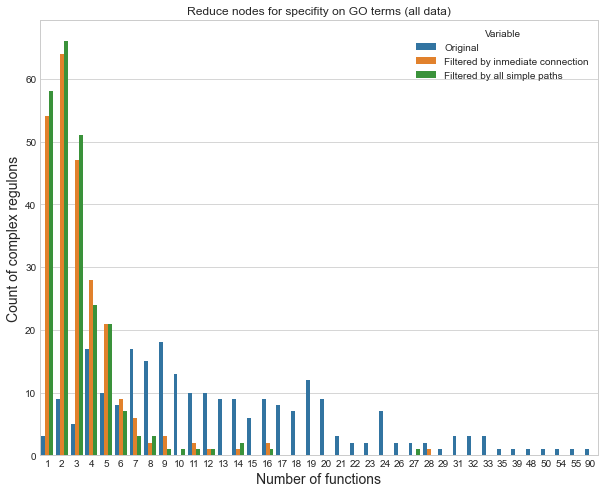

In [18]:
sns.countplot(x="value", hue="variable", data=cr_df_gos_n)
plt.legend(["Original", "Filtered by inmediate connection", "Filtered by all simple paths"], title = "Variable", loc=1)
plt.title("Reduce nodes for specifity on GO terms (all data)")
plt.xlabel("Number of functions")
plt.ylabel("Count of complex regulons");

##### Only complex regulon data (number of TFs > 1)

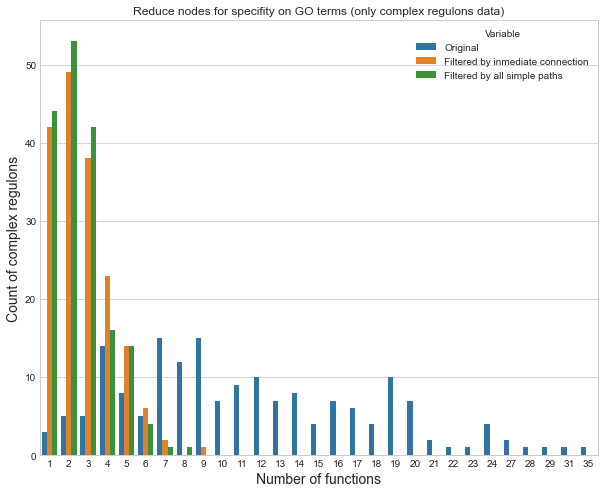

In [19]:
sns.countplot(x="value", hue="variable", data=cr_df_gos_n.query("n_components > 1"))
plt.legend(["Original", "Filtered by inmediate connection", "Filtered by all simple paths"], title = "Variable", loc=1)
plt.title("Reduce nodes for specifity on GO terms (only complex regulons data)")
plt.xlabel("Number of functions")
plt.ylabel("Count of complex regulons");

### Add metadata to complex regulons

The best filtering method was the one that uses all the paths that reach the target node. Therefore, the filter column was renamed to simply `go_id`. Subsequently, we added all the metadata found in the gene ontology network to expand the existing information from the initial data.

#### General info

In [20]:
cr_df_info = (
    cr_df_gos["go_id_filtered_all"].
    apply(list).
    explode().
    reset_index().
    rename(columns = {"go_id_filtered_all": "go_id"}).
    pipe(lambda df: pd.concat([df, pd.json_normalize(df.go_id.apply(lambda x: G.nodes[x]))], axis = 1))
)
cr_df_info.head()

,group_name,go_id,name,namespace,alt_id,def,subset,synonym,is_a,xref,relationship,comment
0,AcrR_CRP_CpxR_Cra_Fis_MarA_MarR_Rob_SoxS,GO:0009408,response to heat,biological_process,[GO:0006951],"""Any process that results in a change in state...",[goslim_yeast],"[""response to heat shock"" NARROW []]","[GO:0006950, GO:0009266]",NaN,NaN,NaN
1,Ada,GO:0006284,base-excision repair,biological_process,NaN,"""In base excision repair, an altered base is r...",NaN,"[""BER"" EXACT []]",[GO:0006281],[Wikipedia:Base_excision_repair],NaN,NaN
2,Ada,GO:0070989,oxidative demethylation,biological_process,NaN,"""The process of removing one or more methyl gr...",[goslim_chembl],NaN,"[GO:0055114, GO:0070988]",NaN,NaN,NaN
3,Ada,GO:0032259,methylation,biological_process,NaN,"""The process in which a methyl group is covale...",[goslim_chembl],NaN,[GO:0008152],[Wikipedia:Methylation],NaN,NaN
4,AdiY_ArgR_CRP_FNR_Fur_GadE_HdfR_IHF_Lrp_Nac,GO:0055114,oxidation-reduction process,biological_process,NaN,"""A metabolic process that results in the remov...",[goslim_pir],"[""oxidation reduction"" EXACT [], ""oxidoreducta...",[GO:0008152],[Wikipedia:Redox],NaN,NaN


#### Complex regulons - Functional dataset

Now that we have a data set with the characteristic functions of each complex regulon, we proceed to obtain an overview of the relationships between the number of components and the number of functions. In addition, a column of the ancestors is included to perform a functional similarity analysis.

In [21]:
cr_df_set = (
    cr_df_info[["group_name", "go_id"]].
    groupby("group_name").
    aggregate(set).
    assign(
        components = lambda df: df.index.str.split("_"),
        n_components = lambda df: df.components.apply(len),
        n_functions = lambda df: df.go_id.apply(len),
        ancestors = lambda df: df.go_id.apply(lambda gos: functools.reduce(set.union, [nx.ancestors(G=G, source=go) for go in gos]))
    ).
    query("n_components > 1")
)
cr_df_set.head()

,go_id,components,n_components,n_functions,ancestors
group_name,,,,,
AcrR_CRP_CpxR_Cra_Fis_MarA_MarR_Rob_SoxS,{GO:0009408},"[AcrR, CRP, CpxR, Cra, Fis, MarA, MarR, Rob, S...",9,1,"{GO:0090442, GO:2000728, GO:0036168, GO:190043..."
AdiY_ArgR_CRP_FNR_Fur_GadE_HdfR_IHF_Lrp_Nac,"{GO:0055114, GO:0019676, GO:0008652}","[AdiY, ArgR, CRP, FNR, Fur, GadE, HdfR, IHF, L...",10,3,"{GO:0019399, GO:1900833, GO:1905446, GO:012021..."
AgaR_CRP,"{GO:0005975, GO:0016310}","[AgaR, CRP]",2,2,"{GO:2000883, GO:0052785, GO:0019406, GO:003440..."
AppY_ArcA_Fis_IscR_NarL_NarP_YdeO,"{GO:0022904, GO:0016485}","[AppY, ArcA, Fis, IscR, NarL, NarP, YdeO]",7,2,"{GO:0035551, GO:1990001, GO:1905446, GO:190544..."
AppY_ArcA_YdeO,"{GO:0016036, GO:0071454, GO:0016311, GO:001964...","[AppY, ArcA, YdeO]",3,5,"{GO:0043666, GO:1905446, GO:1905447, GO:008016..."


##### Visualization

Relationship between the number of components of a complex regulon and the number of associated functions.

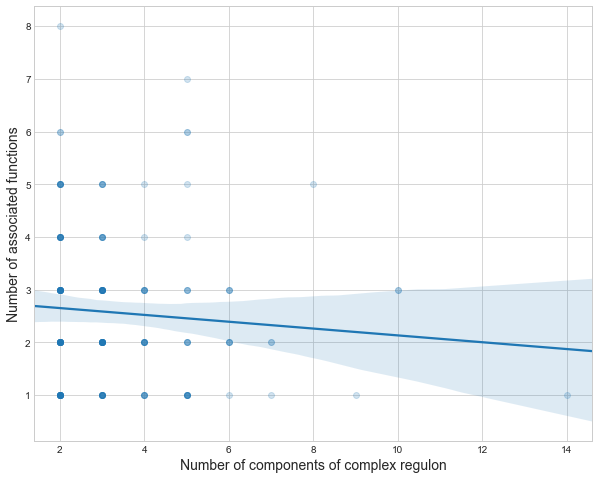

In [22]:
sns.regplot(x="n_components", y="n_functions", data=cr_df_set, truncate=False, scatter_kws={"alpha":1/5})
plt.xlabel("Number of components of complex regulon")
plt.ylabel("Number of associated functions");

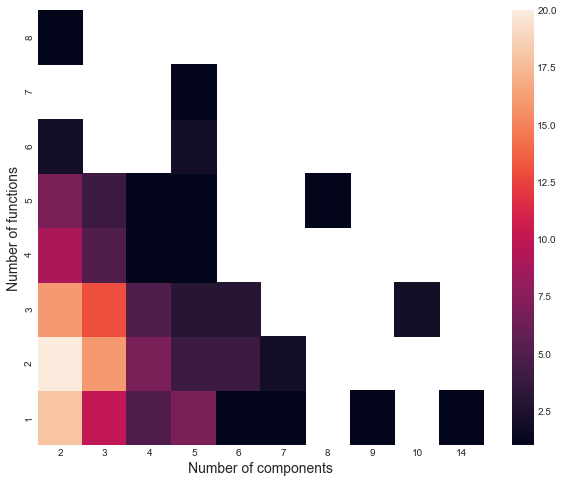

In [23]:
paired_counts = (
    cr_df_set.
    reset_index().
    groupby(["n_components", "n_functions"]).
    size().
    reset_index().
    pivot(index="n_functions", columns="n_components")[0]
)
ax = sns.heatmap(paired_counts)
ax.invert_yaxis()
plt.xlabel("Number of components")
plt.ylabel("Number of functions");

#### Complex regulons by TF - Functional dataset

From the data set mentioned in the previous section, we proceeded to characterize the associated functions for each participating TF in the different complex regulons.

In [24]:
cr_df_set_tf = (
    cr_df_set[["go_id", "components"]].
    reset_index().
    explode("components").
    groupby("components").
    aggregate(list).
    assign(
        group_name = lambda df: df.group_name.apply(set),
        go_id = lambda df: df.go_id.apply(lambda x: functools.reduce(set.union, x)),
        go_id_filtered_all = lambda df: df.go_id.apply(reduce_nodes_gos, inmediate=False),
        n_groups = lambda df: df.group_name.apply(len),
        n_functions = lambda df: df.go_id_filtered_all.apply(len),
        n_func_difference = lambda df: (df.n_functions - df.go_id.apply(len)).abs()
    )
)
cr_df_set_tf.head()

,group_name,go_id,go_id_filtered_all,n_groups,n_functions,n_func_difference
components,,,,,,
AcrR,{AcrR_CRP_CpxR_Cra_Fis_MarA_MarR_Rob_SoxS},{GO:0009408},{GO:0009408},1,1,0
AdiY,{AdiY_ArgR_CRP_FNR_Fur_GadE_HdfR_IHF_Lrp_Nac},"{GO:0055114, GO:0019676, GO:0008652}","{GO:0055114, GO:0019676, GO:0008652}",1,3,0
AgaR,{AgaR_CRP},"{GO:0005975, GO:0016310}","{GO:0005975, GO:0016310}",1,2,0
AppY,"{AppY_ArcA_YdeO, AppY_ArcA_Fis_IscR_NarL_NarP_...","{GO:0016036, GO:0022904, GO:0016311, GO:001964...","{GO:0016036, GO:0071454, GO:0016485, GO:001631...",2,6,1
AraC,"{AraC_CRP, AraC_CRP_XylR}","{GO:0019568, GO:0006520, GO:0005998, GO:004284...","{GO:0046835, GO:0042843, GO:0006520, GO:000599...",2,5,1


##### Visualization

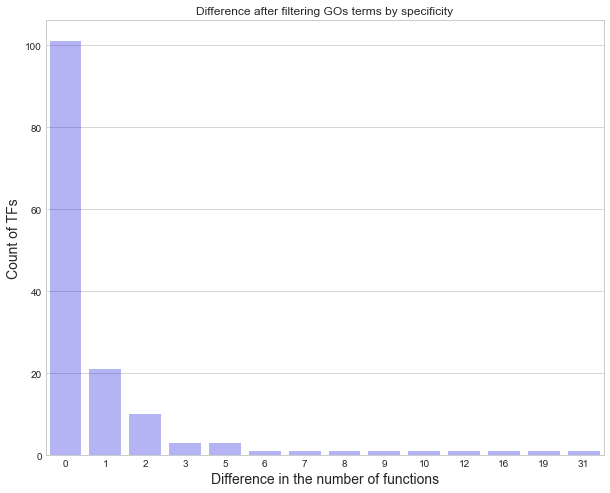

In [25]:
sns.countplot(x="n_func_difference", data=cr_df_set_tf, color="blue", alpha=1/3)
plt.title("Difference after filtering GOs terms by specificity")
plt.xlabel("Difference in the number of functions")
plt.ylabel("Count of TFs");

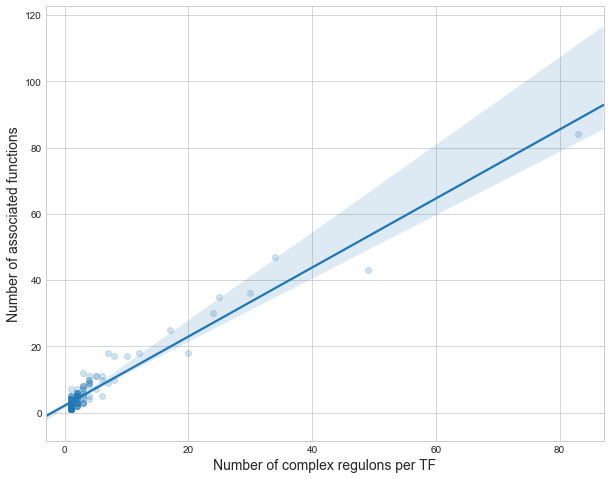

In [26]:
sns.regplot(x="n_groups", y="n_functions", data=cr_df_set_tf, truncate=False, scatter_kws={"alpha":1/5})
plt.xlabel("Number of complex regulons per TF")
plt.ylabel("Number of associated functions");

## Analysis

Now that we have the basic characteristic functions of each type of data, **complex regulon** or **by TF**, we can proceed to carry out a **functional similarity analysis** based on shared ancestors (**GO terms**) using some set similarity metric, in our case, **jaccard index**.

>**Note:** The following is the declaration of partial functions using the `functools.partial` function, which allows us to define the default values of our new function, which makes it easier for us to call new functions only with the arguments that, it is known, they want to modify.

### Similarity of functions

To keep all the plots to a standard. Feel free to modify this or even not use a partial function so that each graph is different. This is because, in general, if the number of elements in a heatmap is different or the labels are of different sizes, the visualization could be improved with these changes.

In [27]:
clustermap = functools.partial(sns.clustermap, xticklabels=True, yticklabels=True, figsize=(20,20))

#### Regulons

Given that the data set that we want to study is the same and that what we want to study is the change in the results depending on the similarity metric, the following values of the `jaccard_df` function are chosen as default:

- **df**=cr_df_set. # Data to analyze.
- **set_colum**="ancestors". # Which column contains the sets to compare?.
- **matrix**=True. # Should the result be delivered in a long or wide format?
- **labels**=["source", "target"]. # Names of the output columns, or pivot columns.

So you can play around with the remaining parameters when you call the function:

- **B:** Use the Cartesian product of the dataframe index in conjunction with the supplied values.
- **kwargs:** Extra arguments to pass to the `jaccard` function.

> For more help, in any function you can go to the notebook `0.3-jvs-setup.ipynb`, or call the `help` function to the `object of interest` to obtain its **documentation**.
>
> Example: 
>
>```python
>help(jaccard_df)
>help(jaccard)
>```

In [28]:
jaccard_matrix_regulon = functools.partial(jaccard_df, df=cr_df_set, set_column="ancestors", matrix=True, labels=["source", "target"])

/opt/anaconda3/envs/set_similarity/lib/python3.8/site-packages/seaborn/matrix.py:659: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


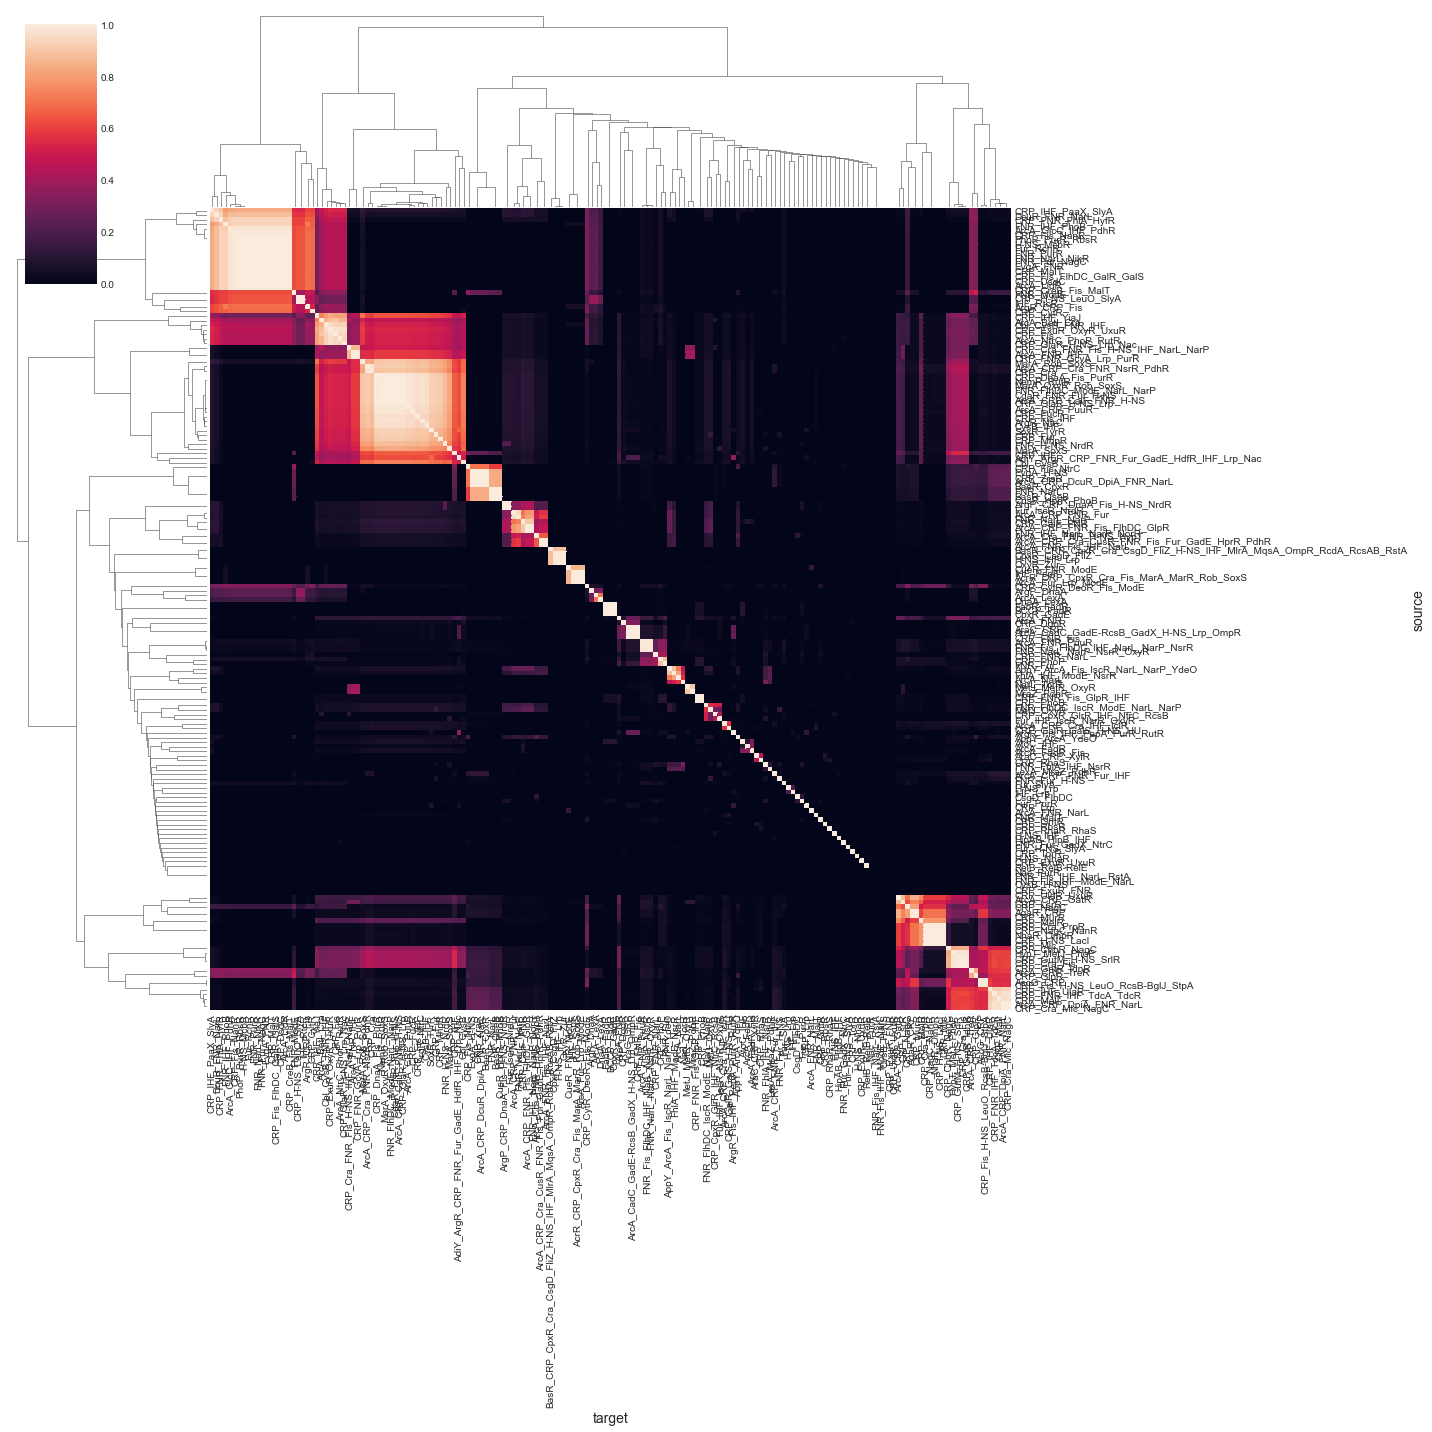

In [29]:
clustermap(jaccard_matrix_regulon())

#### Tfs

As in the previous section, we work with the similarity of functions, only now we consider the union of the functions of a TF in all its complex regulons.

In [30]:
jaccard_matrix_tf = functools.partial(jaccard_df, df=cr_df_set_tf, set_column="go_id_filtered_all", matrix=True, labels=["source", "target"])

/opt/anaconda3/envs/set_similarity/lib/python3.8/site-packages/seaborn/matrix.py:659: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


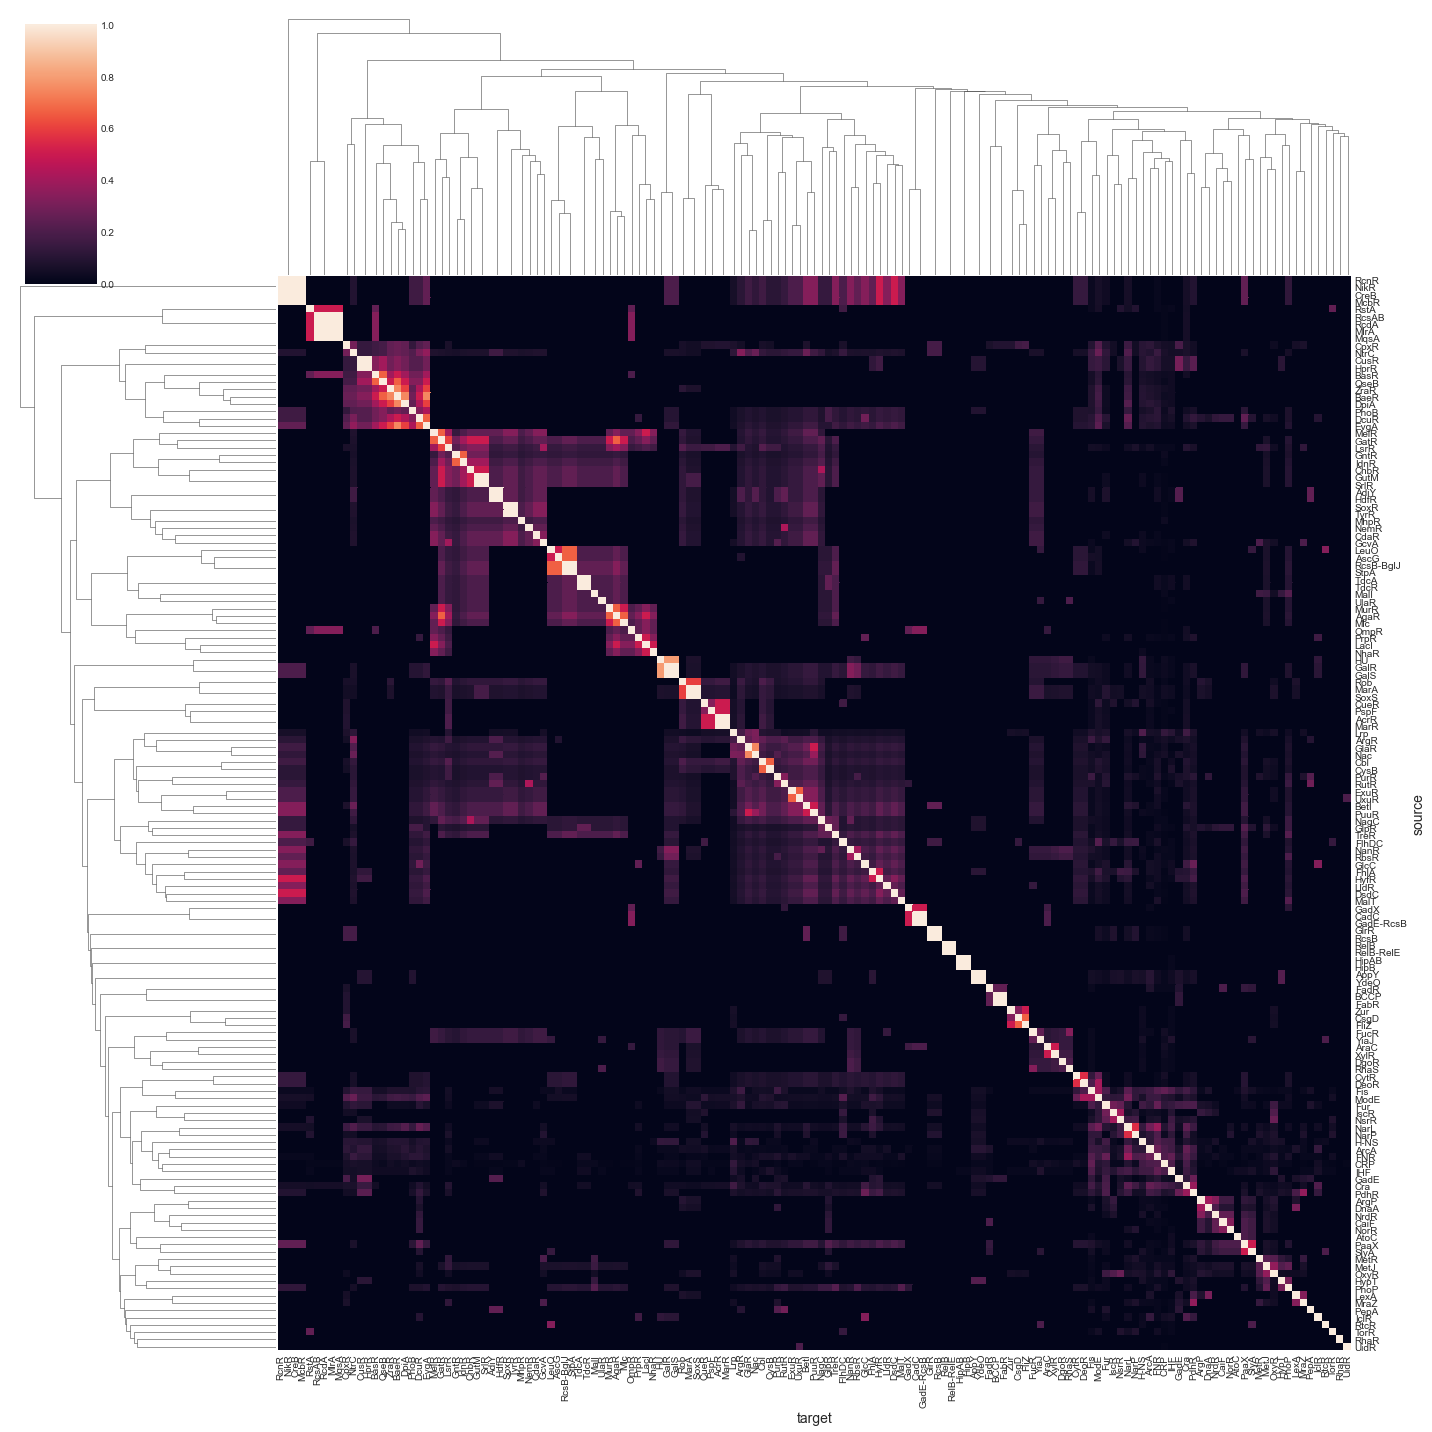

In [31]:
clustermap(jaccard_matrix_tf())